In this competition, our aim is to develop an AI model that can score student essays. This competition is actually an updated version of an old one that took place over a decade ago. In this version, we aim to improve upon essay scoring algorithms to enhance student learning outcomes.

Given an essay with n words X = {xi}i=1 to n, we need to output one score y as a result of measuring the level of this essay.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib as mpl

cmap = mpl.cm.get_cmap('coolwarm')
import torch
import torch.nn as nn
import re
import transformers
from transformers import AutoModel, AutoTokenizer, BertModel, BertTokenizer, BertConfig
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import cohen_kappa_score
import sys
sys.path.append('/kaggle/input/py-file')
from torch_shallow_neural_classifier import TorchShallowNeuralClassifier

/tmp/ipykernel_26/1570875491.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap('coolwarm')


# ⚙️ | Configuration

In [2]:
class CFG:
    seed = 42  # Random seed 
    sequence_length = 512  # Input sequence length
    batch_size = 32  # Batch size
    weights_name = "/kaggle/input/bert-mini"# Name of pretrained models
    #weights_name = "/kaggle/input/bert-base-uncased/pytorch/model_rater/3"

In [3]:
# Fine-tune the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Use GPU if available

# ♻️ | Reproducibility 
Sets value for random seed to produce similar result in each run.

In [4]:
torch.manual_seed(CFG.seed)
transformers.logging.set_verbosity_error()

# 📁 | Dataset Path 

In [5]:
BASE_PATH = '/kaggle/input/learning-agency-lab-automated-essay-scoring-2'

# 📖 | Meta Data

**Files in the dataset:**

- `{test|train}.csv`
  - `essay_id`: Unique identifier for each essay.
  - `full_text`: Essay text.
  - `score`: Essay's score from `1-6`.
- `sample_submission.csv`: Valid sample submission.

**What does the `score` mean?**

The `score` represents the quality of student-written argumentative essays. Essays were rated based on a rubric covering perspective development, critical thinking, evidence use, organization, language, and grammar/mechanics. Here's a summary of the scoring criteria:

| Score | Description |
|-------|-------------|
| 6     | Clear mastery with few errors, outstanding critical thinking, appropriate evidence, well-organized, skilled language use. |
| 5     | Reasonable mastery with occasional errors, strong critical thinking, generally appropriate evidence, well-organized, good language use. |
| 4     | Adequate mastery with some lapses, competent critical thinking, adequate evidence, generally organized, fair language use. |
| 3     | Developing mastery with weaknesses, limited critical thinking, inconsistent evidence, limited organization, fair language use with weaknesses. |
| 2     | Little mastery with serious flaws, weak critical thinking, insufficient evidence, poor organization, limited language use with frequent errors. |
| 1     | Very little or no mastery, severely flawed, no viable point of view, disorganized, fundamental language flaws, pervasive grammar/mechanics errors. |

> This grading is very similar to the grading used in the [ETS GRE (Graduate Record Examinations) AWA](https://www.ets.org/gre/test-takers/general-test/prepare/content/analytical-writing.html) exam, where prospective graduate students are asked to write essays to judge their analytical abilities, and their scores are later used for graduate admission. 


In [6]:
# Load data
df = pd.read_csv(f'{BASE_PATH}/train.csv')  # Read CSV file into a DataFrame

In [7]:
# Display information about the train data
print("# Train Data: {:,}".format(len(df)))
# Set the display options to show the maximum column width
pd.set_option('display.max_colwidth', None)

#display(df['full_text'])
df.head(2)

# Train Data: 17,307


,essay_id,full_text,score
0,000d118,"Many people have car where they live. The thing they don't know is that when you use a car alot of thing can happen like you can get in accidet or the smoke that the car has is bad to breath on if someone is walk but in VAUBAN,Germany they dont have that proble because 70 percent of vauban's families do not own cars,and 57 percent sold a car to move there. Street parkig ,driveways and home garages are forbidden on the outskirts of freiburd that near the French and Swiss borders. You probaly won't see a car in Vauban's streets because they are completely ""car free"" but If some that lives in VAUBAN that owns a car ownership is allowed,but there are only two places that you can park a large garages at the edge of the development,where a car owner buys a space but it not cheap to buy one they sell the space for you car for $40,000 along with a home. The vauban people completed this in 2006 ,they said that this an example of a growing trend in Europe,The untile states and some where else are suburban life from auto use this is called ""smart planning"". The current efforts to drastically reduce greenhouse gas emissions from tailes the passengee cars are responsible for 12 percent of greenhouse gas emissions in Europe and up to 50 percent in some car intensive in the United States. I honeslty think that good idea that they did that is Vaudan because that makes cities denser and better for walking and in VAUBAN there are 5,500 residents within a rectangular square mile. In the artical David Gold berg said that ""All of our development since World war 2 has been centered on the cars,and that will have to change"" and i think that was very true what David Gold said because alot thing we need cars to do we can go anyway were with out cars beacuse some people are a very lazy to walk to place thats why they alot of people use car and i think that it was a good idea that that they did that in VAUBAN so people can see how we really don't need car to go to place from place because we can walk from were we need to go or we can ride bycles with out the use of a car. It good that they are doing that if you thik about your help the earth in way and thats a very good thing to. In the United states ,the Environmental protection Agency is promoting what is called ""car reduced""communtunties,and the legislators are starting to act,if cautiously. Maany experts expect pubic transport serving suburbs to play a much larger role in a new six years federal transportation bill to approved this year. In previous bill,80 percent of appropriations have by law gone to highways and only 20 percent to other transports. There many good reason why they should do this.",3
1,000fe60,"I am a scientist at NASA that is discussing the ""face"" on mars. I will be explaining how the ""face"" is a land form. By sharing my information about this isue i will tell you just that.\n\nFirst off, how could it be a martions drawing. There is no plant life on mars as of rite now that we know of, which means so far as we know it is not possible for any type of life. That explains how it could not be made by martians. Also why and how would a martion build a face so big. It just does not make any since that a martian did this.\n\nNext, why it is a landform. There are many landforms that are weird here in America, and there is also landforms all around the whole Earth. Many of them look like something we can relate to like a snake a turtle a human... So if there are landforms on earth dont you think landforms are on mars to? Of course! why not? It's just unique that the landform on Mars looks like a human face. Also if there was martians and they were trying to get our attention dont you think we would have saw one by now?\n\nFinaly, why you should listen to me. You should listen to me because i am a member of NASA and i've been dealing with all of this stuff that were talking about and people who say martians did this have no relation with NASA

Here we set ourselves up to use BERT-mini:

In [8]:
bert = AutoModel.from_pretrained(CFG.weights_name)

bert_tokenizer = AutoTokenizer.from_pretrained(CFG.weights_name)

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [9]:
def clean_text(text):
    # Replace "\n\n" with a single space
    cleaned_text = re.sub(r'\n\n', ' ', text)
    # Replace "\'" with "'"
    cleaned_text = re.sub(r"\\'", "'", cleaned_text)
    return cleaned_text

In [10]:
df["cleaned_full_text"]=df["full_text"].apply(lambda x:clean_text(x))

# 🔪 | Data Split

In the code snippet provided below, we will divide the existing **train** data into folds using a stratification of `label` column.

In [11]:
train_df, valid_df = train_test_split(df, test_size=0.2, stratify=df["score"])

In [12]:
train_df.head(2)

,essay_id,full_text,score,cleaned_full_text
6568,6226875,"In the article said that is dangerous to explore Venus because it has a thick atmosphere of 97 percent carbon dioxide and the highly corrosive sulfuric acid clouds it has over 800 degrees fahrenheit and the atmospheric presssure is 90 times greater that we experience, Venus has the hottest surface temperature of any planet in our solar system, it has many natural disasters like erupting volcanoes, powerful eartquakes and frequent lightning strikes, Venus is the planet that is some how similar to the earth, they can go there but it only have limited insight, the author supporsts his idea telling us many details of how Venus is dangerous to explore and how the NASA trys to explore inventing many objects that are going to work inside the planet, this planet is the closest planet to earth that is why they really want to explore it, in conclusion i think he really support this idea because in every paragraph he tells us how dangerous and how is different to the earth,to explore this planet they have to invent objects that can work there because this melts every type of technology they want to use , explore this planet is very challenging.",2,"In the article said that is dangerous to explore Venus because it has a thick atmosphere of 97 percent carbon dioxide and the highly corrosive sulfuric acid clouds it has over 800 degrees fahrenheit and the atmospheric presssure is 90 times greater that we experience, Venus has the hottest surface temperature of any planet in our solar system, it has many natural disasters like erupting volcanoes, powerful eartquakes and frequent lightning strikes, Venus is the planet that is some how similar to the earth, they can go there but it only have limited insight, the author supporsts his idea telling us many details of how Venus is dangerous to explore and how the NASA trys to explore inventing many objects that are going to work inside the planet, this planet is the closest planet to earth that is why they really want to explore it, in conclusion i think he really support this idea because in every paragraph he tells us how dangerous and how is different to the earth,to explore this planet they have to invent objects that can work there because this melts every type of technology they want to use , explore this planet is very challenging."
1215,1343a02,"Dear fellow citizens I think you should join the United Nations Relief and Rehabilitation Administrarion. I think you should join becase it is a very nice thing to do. You also get to take care of animals and food on a boat. By doing this you can help countries in need.\n\nMany people say that this is a boring job or useless but if they would try it they might see actually how good of a job it is. If you have this job you get to travel the world. You also get to see many outstanding places around the world. You get to explore oceans. While on the boat when we don't have any animals we play games like baseball, boxing, and table-tennis. Doing this beats sitting in a chair behind a desk filling out papers but I guess some people would rather do that then explore.\n\nIf you are looking for a helping and traveling job this is the one for you. Please go for this job traveling the world instead of sitting in an office building. Many people will say that this job is too much hard work. It does take some hard work but that is good for the body. I hope to see you on the next job.",3,"Dear fellow citizens I think you should join the United Nations Relief and Rehabilitation Administrarion. I think you should join becase it is a very nice thing to do. You also get to take care of animals and food on a boat. By doing this you can help countries in need. Many people say that this is a boring job or useless but if they would try it they might see actually how good of a job it is. If you have this job you get to travel the world. You also get to see many outstanding places around the world. You get to explor

# 🧂 | Process Labels for Ordinal Regression

**What is Ordinal Regression?**
Ordinal regression is a type of supervised learning algorithm used to predict an ordinal or ranked dependent variable. Unlike in typical classification problems where the target variable is categorical, in ordinal regression the target variable has a ordering or ranking. It is also different from typical regression, where the target variable is continuous. In ordinal regression, the target variable has a discrete, ordered set of values, such as levels of satisfaction or performance grades.

**Why do we need it?**
Ordinal regression is useful when the target variable (in our competition, the `score` of an essay) represents a ranking or order. Specifically, ordinal regression can capture the inherent order in the target variable, which standard classification models may not be able to do effectively.

For Ordinal Regression, we have to transform the labels, which is different from typical classification or regression. The following code will convert essay scores to an ordinal matrix, which will be used as the ground truth for calculating the loss.

In [13]:
def to_ordinal(y, num_classes=None, dtype="int"):
    """Converts a class vector (integers) to an ordinal regression matrix.

    This utility encodes class vector to ordinal regression/classification
    matrix where each sample is indicated by a row and rank of that sample is
    indicated by number of ones in that row.

    Args:
        y: Array-like with class values to be converted into a matrix
            (integers from 0 to `num_classes - 1`).
        num_classes: Total number of classes. If `None`, this would be inferred
            as `max(y) + 1`.
        dtype: The data type expected by the input. Default: `'float32'`.

    Returns:
        An ordinal regression matrix representation of the input as a NumPy
        array. The class axis is placed last.
    """
    y = np.array(y, dtype="int")
    input_shape = y.shape

    # Shrink the last dimension if the shape is (..., 1).
    if input_shape and input_shape[-1] == 1 and len(input_shape) > 1:
        input_shape = tuple(input_shape[:-1])

    y = y.reshape(-1)
    if not num_classes:
        num_classes = np.max(y) + 1
    n = y.shape[0]
    range_values = np.arange(num_classes - 1)
    range_values = np.tile(np.expand_dims(range_values, 0), [n, 1])
    ordinal = np.zeros((n, num_classes - 1), dtype=dtype)
    ordinal[range_values < np.expand_dims(y, -1)] = 1
    output_shape = input_shape + (num_classes - 1,)
    ordinal = np.reshape(ordinal, output_shape)
    return ordinal

## Label Conversion

In [14]:
train_df["label"] = to_ordinal(train_df.score.values).tolist()
valid_df["label"] = to_ordinal(valid_df.score.values).tolist()

In [15]:
train_df.head(2)

,essay_id,full_text,score,cleaned_full_text,label
6568,6226875,"In the article said that is dangerous to explore Venus because it has a thick atmosphere of 97 percent carbon dioxide and the highly corrosive sulfuric acid clouds it has over 800 degrees fahrenheit and the atmospheric presssure is 90 times greater that we experience, Venus has the hottest surface temperature of any planet in our solar system, it has many natural disasters like erupting volcanoes, powerful eartquakes and frequent lightning strikes, Venus is the planet that is some how similar to the earth, they can go there but it only have limited insight, the author supporsts his idea telling us many details of how Venus is dangerous to explore and how the NASA trys to explore inventing many objects that are going to work inside the planet, this planet is the closest planet to earth that is why they really want to explore it, in conclusion i think he really support this idea because in every paragraph he tells us how dangerous and how is different to the earth,to explore this planet they have to invent objects that can work there because this melts every type of technology they want to use , explore this planet is very challenging.",2,"In the article said that is dangerous to explore Venus because it has a thick atmosphere of 97 percent carbon dioxide and the highly corrosive sulfuric acid clouds it has over 800 degrees fahrenheit and the atmospheric presssure is 90 times greater that we experience, Venus has the hottest surface temperature of any planet in our solar system, it has many natural disasters like erupting volcanoes, powerful eartquakes and frequent lightning strikes, Venus is the planet that is some how similar to the earth, they can go there but it only have limited insight, the author supporsts his idea telling us many details of how Venus is dangerous to explore and how the NASA trys to explore inventing many objects that are going to work inside the planet, this planet is the closest planet to earth that is why they really want to explore it, in conclusion i think he really support this idea because in every paragraph he tells us how dangerous and how is different to the earth,to explore this planet they have to invent objects that can work there because this melts every type of technology they want to use , explore this planet is very challenging.","[1, 1, 0, 0, 0, 0]"
1215,1343a02,"Dear fellow citizens I think you should join the United Nations Relief and Rehabilitation Administrarion. I think you should join becase it is a very nice thing to do. You also get to take care of animals and food on a boat. By doing this you can help countries in need.\n\nMany people say that this is a boring job or useless but if they would try it they might see actually how good of a job it is. If you have this job you get to travel the world. You also get to see many outstanding places around the world. You get to explore oceans. While on the boat when we don't have any animals we play games like baseball, boxing, and table-tennis. Doing this beats sitting in a chair behind a desk filling out papers but I guess some people would rather do that then explore.\n\nIf you are looking for a helping and traveling job this is the one for you. Please go for this job traveling the world instead of sitting in an office building. Many people will say that this job is too much hard work. It does take some hard work but that is good for the body. I hope to see you on the next job.",3,"Dear fellow citizens I think you should join the United Nations Relief and Rehabilitation Administrarion. I think you should join becase it is a very nice thing to do. You also get to take care of animals and food on a boat. By doing this you can help countries in need. Many people say that this is a boring job or useless but if they would try it they might see actually how good of a job it is. If you have this job you get to travel the world. You also get to see many outstanding places around t

# 🎨 |Data Visualization

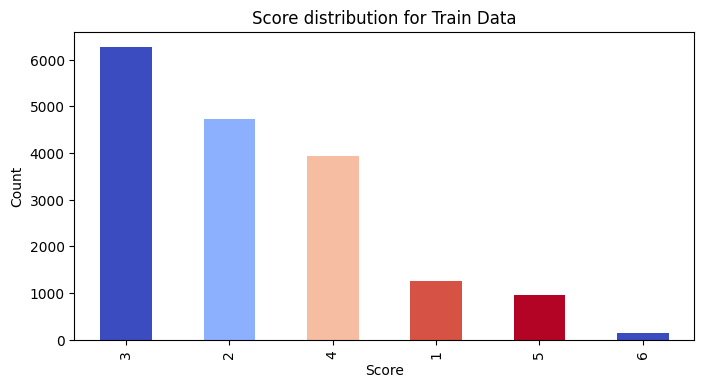

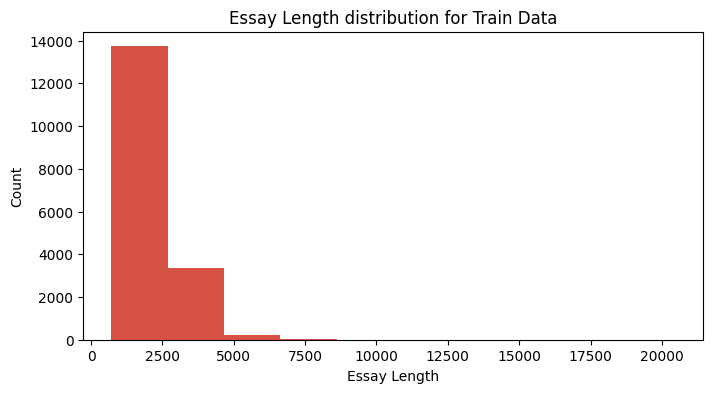

In [16]:
# Show distribution of answers using a bar plot
plt.figure(figsize=(8, 4))
df.score.value_counts().plot.bar(color=[cmap(0.0), cmap(0.25), cmap(0.65), cmap(0.9), cmap(1.0)])
plt.xlabel("Score")
plt.ylabel("Count")
plt.title("Score distribution for Train Data")
plt.show()

# Show distribution of essay length using a bar plot
plt.figure(figsize=(8, 4))
df['essay_length'] = df.full_text.map(len)
df.essay_length.plot.hist(logy=False, color=cmap(0.9))
plt.xlabel("Essay Length")
plt.ylabel("Count")
plt.title("Essay Length distribution for Train Data")
plt.show()

# 🍽️ | Preprocessing

**What it does:** The preprocessor takes input strings and transforms them into a dictionary (`token_ids`, `padding_mask`) containing preprocessed tensors. This process starts with tokenization, where input strings are converted into sequences of token IDs.

**Why it's important:** Initially, raw text data is complex and challenging for modeling due to its high dimensionality. By converting text into a compact set of tokens, such as transforming `"The quick brown fox"` into `["the", "qu", "##ick", "br", "##own", "fox"]`, we simplify the data. Many models rely on special tokens and additional tensors to understand input. These tokens help divide input and identify padding, among other tasks. Making all sequences the same length through padding boosts computational efficiency, making subsequent steps smoother.

### Batch tokenization
use the batch_encode_plus method for bert_tokenizer to tokenize a list of strings.

In [17]:
def get_batch_token_ids(batch, tokenizer):
    """Map `batch` to a tensor of ids. The return
    value should meet the following specification:

    1. The max length should be 512.
    2. Examples longer than the max length should be truncated
    3. Examples should be padded to the max length for the batch.
    4. The special [CLS] should be added to the start and the special
       token [SEP] should be added to the end.
    5. The attention mask should be returned
    6. The return value of each component should be a tensor.

    Parameters
    ----------
    batch: list of str
    tokenizer: Hugging Face tokenizer

    Returns
    -------
    dict with at least "input_ids" and "attention_mask" as keys,
    each with Tensor values

    """
    # Encode the concatenated string
    encoding = tokenizer.batch_encode_plus(batch, max_length=CFG.sequence_length, padding='max_length',
                                     truncation=True, return_tensors='pt', add_special_tokens=True)

    return encoding

### Fine-tuning module
1. in the init method, define self.classifier_layer using nn.Sequential
2. Complete the forward method.

In [18]:
class BertClassifierModule(nn.Module):
    def __init__(self,
            n_classes,
            hidden_activation,
            weights_name=CFG.weights_name):
        """This module loads a Transformer based on  `weights_name`,
        puts it in train mode, add a dense layer with activation
        function give by `hidden_activation`, and puts a classifier
        layer on top of that as the final output. The output of
        the dense layer should have the same dimensionality as the
        model input.

        Parameters
        ----------
        n_classes : int
            Number of classes for the output layer
        hidden_activation : torch activation function
            e.g., nn.Tanh()
        weights_name : str
            Name of pretrained model to load from Hugging Face

        """
        super().__init__()
        self.n_classes = n_classes
        self.weights_name = CFG.weights_name
        self.bert = AutoModel.from_pretrained(self.weights_name)
        self.bert.train()
        self.hidden_activation = hidden_activation
        self.hidden_dim = self.bert.embeddings.word_embeddings.embedding_dim
        # Add the new parameters here using `nn.Sequential`.
        # We can define this layer as
        #
        #  h = f(cW1 + b_h)
        #  y = hW2 + b_y
        #
        # where c is the final hidden state above the [CLS] token,
        # W1 has dimensionality (self.hidden_dim, self.hidden_dim),
        # W2 has dimensionality (self.hidden_dim, self.n_classes),
        # f is the hidden activation, and we rely on the PyTorch loss
        # function to add apply a softmax to y.
        self.classifier_layer = None
        ##### YOUR CODE HERE
       # Define the classifier_layer using nn.Sequential
        
        self.classifier_layer = nn.Sequential(
            nn.Linear(self.hidden_dim,self.hidden_dim),  
            self.hidden_activation,      # Activation function
            nn.Linear(self.hidden_dim, self.n_classes)
        )

    def forward(self, indices, mask):
        """Process `indices` with `mask` by feeding these arguments
        to `self.bert` and then feeding the initial hidden state
        in `last_hidden_state` to `self.classifier_layer`

        Parameters
        ----------
        indices : tensor.LongTensor of shape (n_batch, k)
            Indices into the `self.bert` embedding layer. `n_batch` is
            the number of examples and `k` is the sequence length for
            this batch
        mask : tensor.LongTensor of shape (n_batch, d)
            Binary vector indicating which values should be masked.
            `n_batch` is the number of examples and `k` is the
            sequence length for this batch

        Returns
        -------
        tensor.FloatTensor
            Predicted values, shape `(n_batch, self.n_classes)`

        """
        # Process indices and mask through self.bert
        outputs = self.bert(indices, attention_mask=mask)

        # Extract the [CLS] token representation
        #cls_token_representation = outputs.last_hidden_state[:, 0, :]
        # Extract all token representations
        last_hidden_state = outputs.last_hidden_state

        # Apply max-pooling across the sequence dimension (dim=1)
        cls_token_representation, _ = torch.max(last_hidden_state, dim=1)

        # Apply the classifier layer
        logits = self.classifier_layer(cls_token_representation)
        return logits

In [19]:
bert_module = BertClassifierModule(n_classes=6, hidden_activation=nn.Tanh())

In [20]:
class BertClassifier(TorchShallowNeuralClassifier):
    def __init__(self, weights_name, *args, **kwargs):
        self.weights_name = CFG.weights_name
        self.tokenizer = AutoTokenizer.from_pretrained(self.weights_name)
        super().__init__(*args, **kwargs)
        self.params += ['weights_name']
        self.classes_ = None
        self.n_classes_ = 6
        
    def build_graph(self):
        return BertClassifierModule(
            self.n_classes_, self.hidden_activation, self.weights_name)

    def build_dataset(self, X, y=None):
        data = get_batch_token_ids(X, self.tokenizer)
        if y is None:
            dataset = torch.utils.data.TensorDataset(
                data['input_ids'], data['attention_mask'])
        else:
            self.classes_ = np.unique(y, axis=0)
            self.n_classes_ = self.classes_.shape[1]
            
            y = np.array(y, dtype=np.float32)
            y_tensor = torch.tensor(y, dtype=torch.float32)
            
            dataset = torch.utils.data.TensorDataset(
                data['input_ids'], data['attention_mask'], y_tensor)
        return dataset

In [21]:
bert_finetune = BertClassifier(
    weights_name=CFG.weights_name,
    hidden_activation=nn.ReLU(),
    hidden_dim=512,
    #max_iter=10,
    eta=0.00005,          # Low learning rate for effective fine-tuning.
    batch_size=32,         # Small batches to avoid memory overload.
    gradient_accumulation_steps=4,  # Increase the effective batch size to 32.
    early_stopping=True,  # Early-stopping
    n_iter_no_change=5)   # params

In [22]:
#bert_finetune

In [23]:
%%time
train_labels = train_df.label.tolist() # Extract training labels
_ = bert_finetune.fit(train_df['cleaned_full_text'].tolist(),train_labels)

Stopping after epoch 24. Validation score did not improve by tol=1e-05 for more than 5 epochs. Final error is 337.7014716863632

CPU times: user 32min 25s, sys: 2.65 s, total: 32min 28s
Wall time: 31min 22s


In [24]:
preds = bert_finetune.predict(valid_df['cleaned_full_text'].tolist())

# 📏 | Metric

The metric for this competition is quadratic **Weighted Kappa**. This metric is particularly useful for tasks involving ordinal classification (where labels have inherent order). The following code implements this metric from scratch. This metric is implemented taking inspiration from [this TensorFlow implementation](https://www.tensorflow.org/addons/api_docs/python/tfa/losses/WeightedKappaLoss). You can learn more about this metric [here](https://www.sciencedirect.com/science/article/abs/pii/S0167865517301666). 

> This metric implementation is a bit different than the competition metric, which was resolved by @taichiuemura in [here](https://www.kaggle.com/code/taichiuemura/aes-2-0-kerasnlp-starter/#%F0%9F%93%8F-%7C-Metric).

## Result Summary

In [25]:
y_true = []
y_true.extend(valid_df['label'])
y_true = np.array(y_true)
preds = np.vstack(preds)
print('sklearn metric:', cohen_kappa_score(
    np.sum(y_true > 0.5, axis = 1),
    np.sum(preds > 0.5, axis = 1),
    weights = 'quadratic',
))


sklearn metric: 0.7371376444221596


# 🧪 | Testing

In this section, we will visually test how our model performs on some samples from the validation data.

> Note that we are converting the ordinal regression model outputs with `sum`, unlike a typical classification problem where we would use `argmax`.

In [26]:
# Format predictions and true answers
pred_scores = np.sum((preds > 0.5).astype(int), axis=-1)
true_scores = valid_df.score.values

# Check 5 Predictions
print("# Predictions\n")
for i in range(5):
    row = valid_df.iloc[i]
    text = row.full_text
    pred_answer = pred_scores[i]
    true_answer = true_scores[i]
    print(f"❓ Text {i+1}:\n{text[:150]} .... {text[-150:]}\n")
    print(f"✅ True: {true_answer}\n")
    print(f"🤖 Predicted: {pred_answer}\n")
    print("-" * 90, "\n")


# Predictions

❓ Text 1:
I think that Luke should get back in the Seagoing Cowboys program,because then he can see the sea, and he like's to take care of the animals he get's  .... o go back home so he can finsh his two job's and then he could go to collage either way i tink that he was a good guy in the Seagoing Cowboys progarm 

✅ True: 1

🤖 Predicted: 1

------------------------------------------------------------------------------------------ 

❓ Text 2:
Have you ever heard of the Seagoing Cowboys program?

The Seagoing Cowboys program is a thing alot of people should do. We help out with alot of stuff .... ar 2 and now its your turn to step up and lend a helping hand. This program is possibly the most helpfullest program in the U.S.A.                    

✅ True: 3

🤖 Predicted: 3

------------------------------------------------------------------------------------------ 

❓ Text 3:
I think they should develop the driverless cars, because it would be something new and most likely 

# 📬 | Submission

In this section, we will infer our model on the test data and then finally prepare the submission file.

## Build Test Dataset

In [27]:
#Test Data
test_df = pd.read_csv(f"{BASE_PATH}/test.csv")

test_texts = test_df.full_text.fillna("").tolist()  # Extract test texts

# Build test dataset
test_preds = bert_finetune.predict(test_texts)


## Inference on Test Data

In [28]:
# Do inference
test_preds = bert_finetune.predict(test_texts)
test_preds = np.vstack(test_preds)
# Convert probabilities to class labels
test_preds = np.sum((test_preds>0.5).astype(int), axis=-1).clip(1, 6)

## Create Submission File

In [29]:
# Create a DataFrame to store the submission
sub_df = test_df[["essay_id"]].copy()

# Add the formatted predictions to the submission DataFrame
sub_df["score"] = test_preds

# Save Submission
sub_df.to_csv('submission.csv',index=False)

# Display the first 2 rows of the submission DataFrame
sub_df.head()

,essay_id,score
0,000d118,2
1,000fe60,3
2,001ab80,4
